# Task 6 - Project work

### 1. Introduction & Objectives

In this project, we aim to create a classification model that predicts the likelihood of loan approval based on various financial and personal factors of loan applicants. We'll first explore decision trees for transparency, followed by random forests to improve model performance.

### 2. Understanding the Data

#### Loading the data and a quick preview
We will load the data sheet

First let's take a peak at the data and see what it looks like in its raw form:

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../Datasets/loan_approval_dataset.csv")


In [11]:
# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Let's check if there is any null values points.

In [12]:
missing_values = df.isnull().sum()
missing_values

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

### Plot the data for analyzing

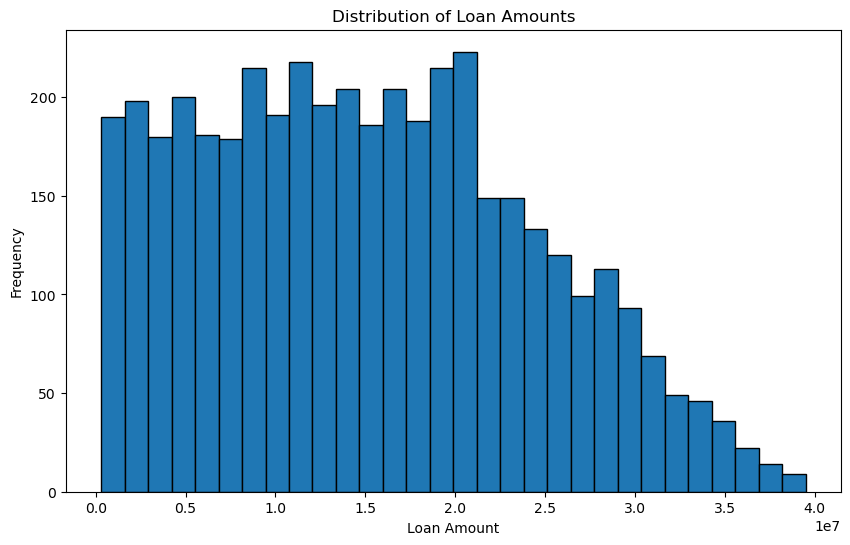

In [39]:
plt.figure(figsize=(10, 6))
df[' loan_amount'].plot(kind='hist', bins=30, edgecolor='black')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Amounts')
plt.show()

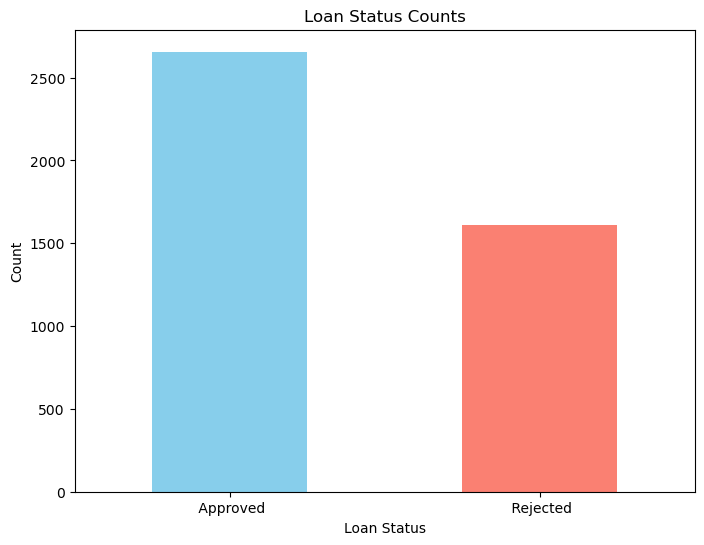

In [41]:

plt.figure(figsize=(8, 6))
df[' loan_status'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Loan Status Counts')
plt.xticks(rotation=0)
plt.show()


<Figure size 1000x600 with 0 Axes>

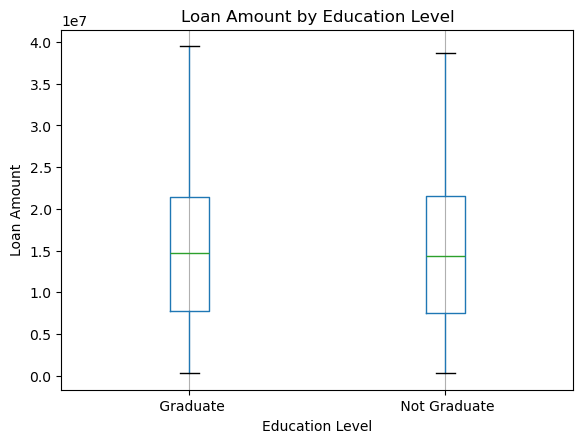

In [55]:
plt.figure(figsize=(10, 6))
df.boxplot(column=' loan_amount', by=' education')
plt.xlabel('Education Level')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Education Level')
plt.suptitle('')  
plt.grid(axis='y')
plt.show()


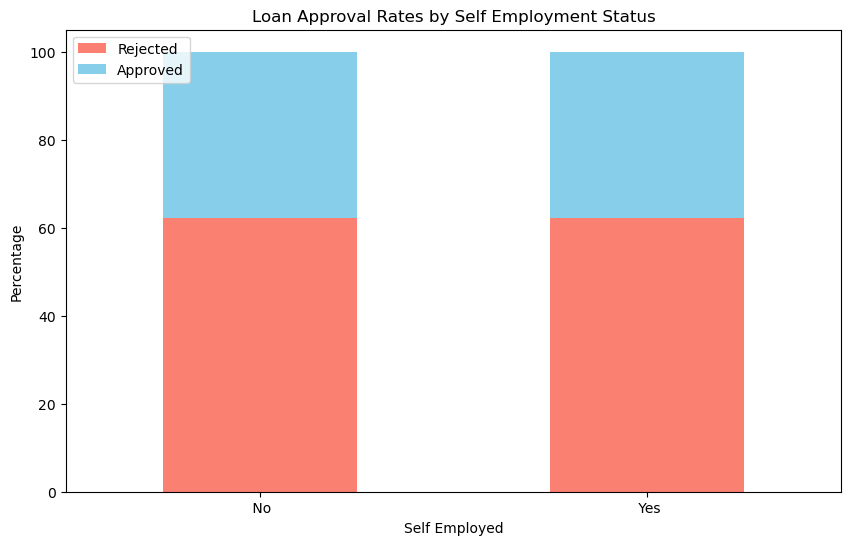

In [56]:
loan_approval_by_self_employed = df.groupby(' self_employed')[' loan_status'].value_counts(normalize=True).unstack() * 100
loan_approval_by_self_employed.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'skyblue'])
plt.xlabel('Self Employed')
plt.ylabel('Percentage')
plt.title('Loan Approval Rates by Self Employment Status')
plt.legend(['Rejected', 'Approved'], loc='upper left')
plt.xticks(rotation=0)
plt.show()


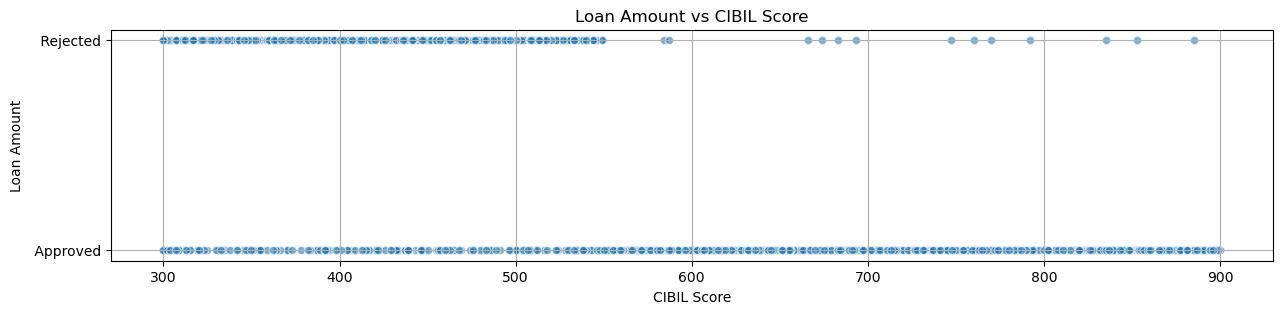

In [67]:
plt.figure(figsize=(15, 3))
plt.scatter(df[' cibil_score'], df[' loan_status'], alpha=0.6, edgecolors='w')
plt.xlabel('CIBIL Score')
plt.ylabel('Loan Amount')
plt.title('Loan Amount vs CIBIL Score')
plt.grid()
plt.show()


<Figure size 1000x600 with 0 Axes>

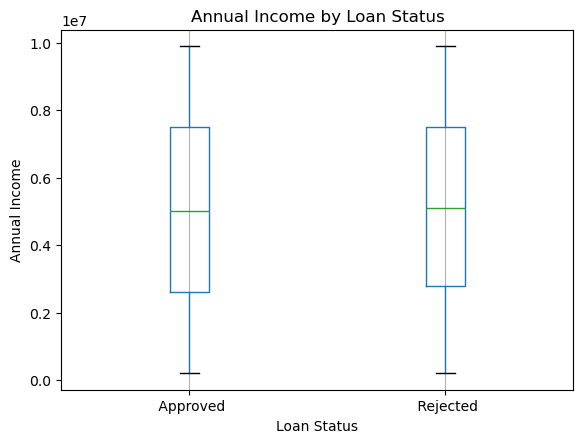

In [58]:
plt.figure(figsize=(10, 6))
df.boxplot(column=' income_annum', by=' loan_status')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.title('Annual Income by Loan Status')
plt.suptitle('')  
plt.grid(axis='y')
plt.show()
